# **Posilňujúce učenie**
 Je to typ strojového učenia, v ktorom sa agent učí robiť rozhodnutia na základe odmien alebo trestov za svoje konanie. Cieľom agenta je maximalizovat kumulatívnu odmenu tým, že sa naučí optimalne zasady, ktoré mapuju výsledky k rozhodnutiam.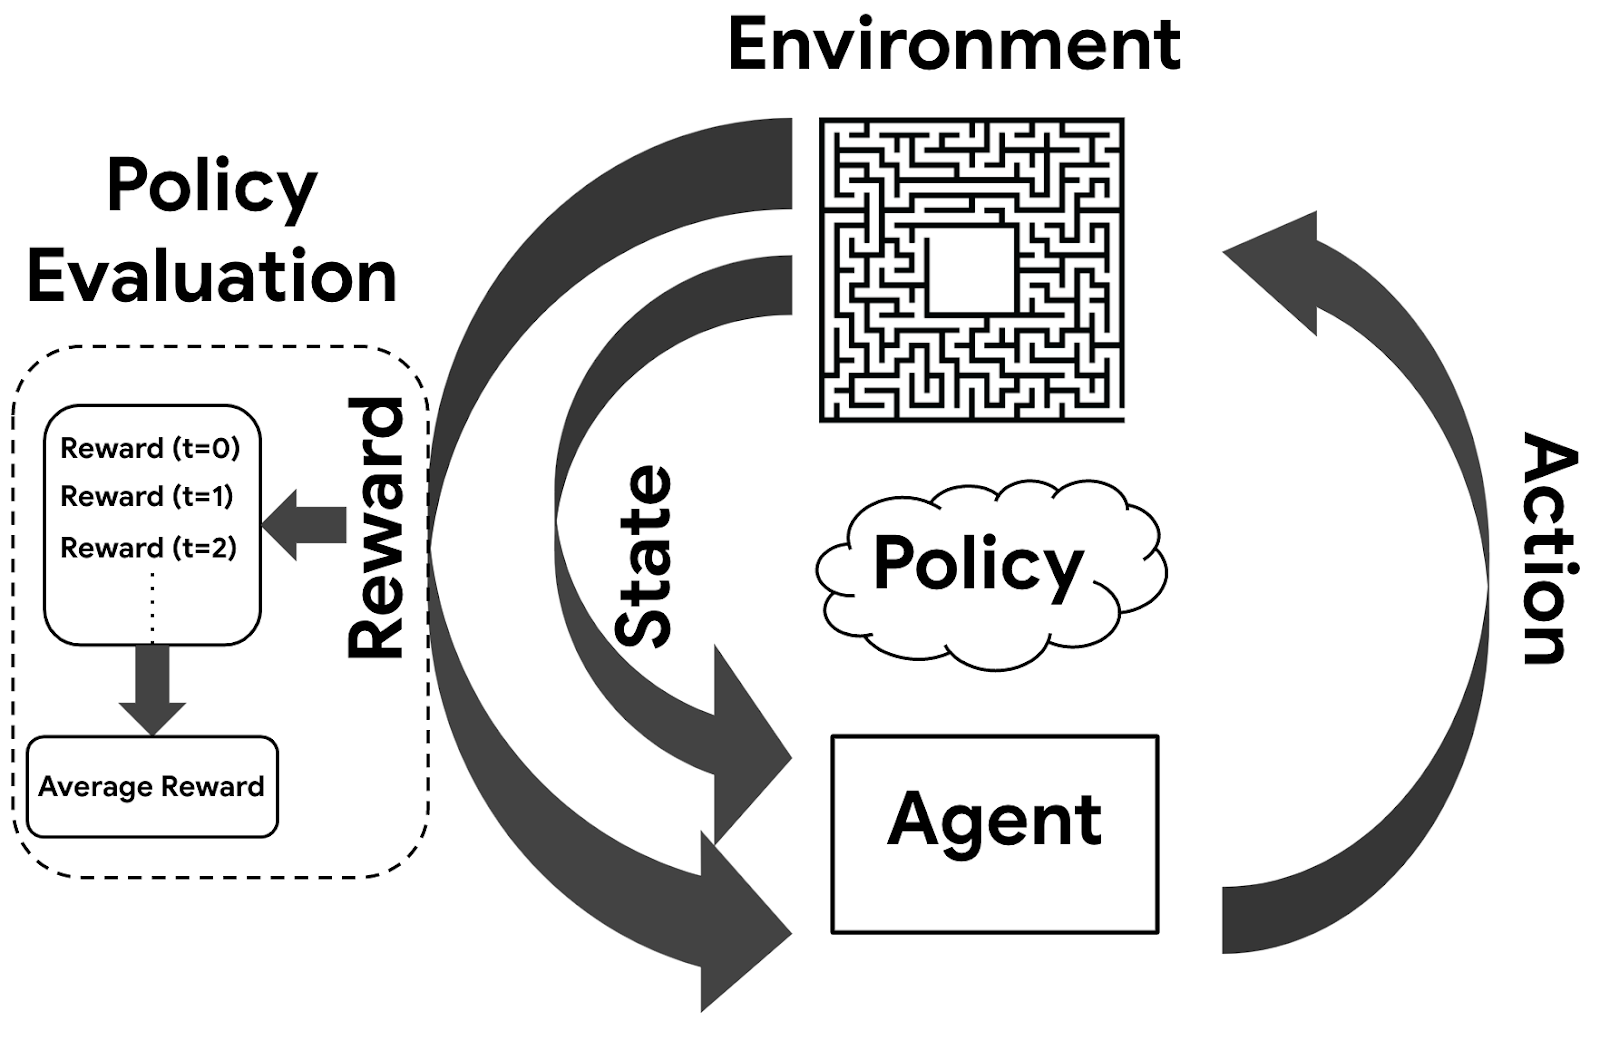

### Terminológia
**Prostredie(Enviroment)** V posilňujúcom učeni je prostredie označenie pre miesto kde náš agent preskúmava a uči sa. Ak by sme agenta učili hrať BlackJack, prostredím by bol hrací stol s kartami.

**Agent(Agent)** Agent je entita, ktorá preskúmava prostredie, interaguje a robí rôzne akcie v prostredí. V príklade BlackJacku by agentom bol hráč.

**Stav(State)** Agent je vždy v nejakom stave, ktorý nám hovorí o statuse agenta. Najčastejším príkladom stavu je poloha agenta v prostredí. Pohyb agenta bude meniť jeho stav.

**Akcia(Action)** Každá interakcia medzi agentom a prostredím je považovaná za akciu. Akcia môže no nemusí zmeniť stav agenta. Aj nič nerobenie je považované za akciu. V prípade BlackJacku by to bolo neťahať dalšiu kartu.

**Odmena(Reward)** Každá akcia, ktorú agent vykoná bude preňho znamenať odmenu určitej výšky(kladná alebo záporná). Cieľom nášho agenta je maximalizovať odmenu. Ak by náš agent v BlackJacku vyhral dostal by kladnú odmenu, naopak ak by prehral alebo potiahol viac kariet ako mal bude odmena negatívna.


Najdôležitejšia čast posilňujúceho učenia je stanovenie ako odmeňovať agenta. To znamená, že by sme ho mali odmenovať adekvátne aby nakoniec dosiahol svoj cieľ.

### Algoritmy posilňujúceho učenia, ktoré budeme používať

DQN

A2C

SAC


# **1. Inštalácia knižnic a videa** 

Najprv potrebujeme naistalovat potrebné kniznice trenovacieho prostredia, RL ucenia a videodispleja

In [16]:
!pip install stable-baselines3[extra]
!apt-get install ffmpeg freeglut3-dev xvfb  
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)


Na zobrazenie vyuzijeme falosny displej

In [17]:
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

sh: 1: Xvfb: not found


In [18]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

# **2. Import prostredia, RL agenta, monitoru ...**


Vyuzijeme prostredie Gymnasium od OpenAI, numpy a z stable baselines importujeme deep-Q-network umelu neuronovu siet.

https://gymnasium.farama.org/  dokumentacia pre prostredie v ktorom trenujeme agentov

https://stable-baselines3.readthedocs.io/en/master/ dokumentacia pre RL algoritmy

In [19]:
import gymnasium as gym
import numpy as np
import tempfile
import os

from stable_baselines3.common.results_plotter import load_results, ts2xy          # import funkci na vyzobrazenie vysledkov
from stable_baselines3.common.noise import NormalActionNoise                      # import dacoho
from stable_baselines3.common.callbacks import BaseCallback                       # import callback funkcie
from stable_baselines3.common.monitor import Monitor                              # na zobrazenie treningoveho progresu
from stable_baselines3.common.callbacks import CheckpointCallback                 # callback pocas treningu
from stable_baselines3 import DQN                                                 # import DQN algoritmu
from stable_baselines3 import SAC                                                 # import SAC algoritmu
from stable_baselines3 import A2C                                                 # import A2C algoritmu

Vytvoríme si Callback funkciu, ktorá bude ukladať model 

In [20]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

# **3. Vytvorenie Gym prostredia a iniciacia agenta**

Pre LunarLander sme si vybrali DQN algoritmus s MLP taktiku pretoze nase prostredie ma vektory a nie obrazky, mozeme to vsak zmenit na SAC alebo A2C algoritmus

In [21]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)          # docasny priecinok na ukladanie progresu treningu

env = gym.make('CartPole-v1')             # vytvorenie prostredia LunarLander(da sa zmenit na iné napr CarRacing-v2)
env = Monitor(env, log_dir)                  # pridanie triedy Monitor do prostredia a virtualneho priecinku, tu sa ukladaju logy 

model = DQN(                      # mozeme zmenit na SAC alebo A2C
    "MlpPolicy",                  # typ neuronovej siete
    env,                          # typ prostredia
    verbose=1,                    # print progresu do konzoly
    #exploration_final_eps=0.1,   # finalna hodnota šance nahodnych akcii namiesto doporučených akcií 
    #target_update_interval=250,  # frekvencia updatu neuronovej siete
    #learning_rate = 0.5          # rýchlosť učenia v intervale <0,1>
    #buffer_size = 1000           # veľkosť buffera na ukladanie skúseností
    #batch_size = 8               # veľkosť vzorky ktorá sa načíta z buffera

)                                  
"""
Tieto zakomentovane hyperparametre nemusíme nastavovať pretože sa nastavia automaticky, no možeme ručne menit ich hodnoty
"""



Using cuda device
Wrapping the env in a DummyVecEnv.


'\nTieto zakomentovane hyperparametre nemusíme nastavovať pretože sa nastavia automaticky, no možeme ručne menit ich hodnoty\n'

Nacitame si pomocnu funkciu, ktora bude hodnotit agenta bez treningu v prostredi

In [22]:
from stable_baselines3.common.evaluation import evaluate_policy

Zhodnotime vykon agenta bez treningu v prostredi

In [23]:
# Separacia prostredia na evaluaciu
eval_env = gym.make("CartPole-v1")

# Nahodny agent bez treningu
mean_reward, std_reward = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=10,
    deterministic=True,
)
# Vypis AVERAGE odmeny agenta bez treningu
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

mean_reward=12.20 +/- 0.7483314773547883


/home/matus/myvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Nahrame agenta bez treningu do videa 

In [24]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

   
    eval_env.close()

In [25]:
record_video("CartPole-v1", model, video_length=600, prefix="noTraining-CartPole-v1")

Saving video to /home/matus/HNS/Zadanie_1/videos/noTraining-CartPole-v1-step-0-to-step-600.mp4
Moviepy - Building video /home/matus/HNS/Zadanie_1/videos/noTraining-CartPole-v1-step-0-to-step-600.mp4.
Moviepy - Writing video /home/matus/HNS/Zadanie_1/videos/noTraining-CartPole-v1-step-0-to-step-600.mp4



Moviepy - Done !
Moviepy - video ready /home/matus/HNS/Zadanie_1/videos/noTraining-CartPole-v1-step-0-to-step-600.mp4


In [26]:
show_videos("videos", prefix="noTraining")

# **4. Tréning agenta**

In [27]:
import matplotlib.pyplot as plt
import pandas as pd 

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

# Trening, trva dlhsie 
model.learn(total_timesteps=int(4e5),callback=callback)

# ulozime agenta ako dqn_lunar 
model.save("CartPole")

# Vymazeme aby sme mohli loadovat neskor
del model  


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 15829    |
|    time_elapsed     | 0        |
|    total_timesteps  | 71       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 21.5     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 17736    |
|    time_elapsed     | 0        |
|    total_timesteps  | 172      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.9     |
|    ep_rew_mean      | 22.9     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes       

Vykreslenie vysledkov učenia

In [28]:
def moving_average(values, window):
    """
    Uhladenie hodnot
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "same")

def plot_results( log_folder, title="Learning progress"):
    
    x1, y1 = ts2xy(load_results(log_dir), "timesteps")
    y1 = moving_average(y1, window=50)
    x1 = x1[len(x1) - len(y1) :]

    plt.plot(x1, y1, color='blue')
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.show()

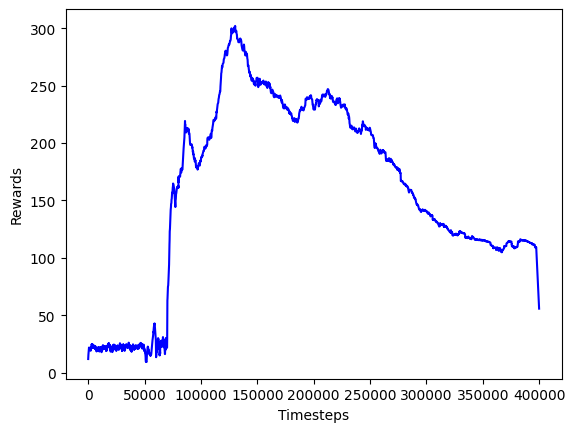

In [29]:
plot_results(log_dir)

# **5. Načítanie agenta**

Mozeme pridat dalsich inak natrenovanych agentov

In [30]:
model = DQN.load("CartPole")

Evaluacia natrenovaneho agenta

In [31]:
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

/home/matus/myvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=112.60 +/- 5.7306195127577615


Nahrame video natrenovaneho agenta

In [35]:
def record_video(env_id, model, video_length=600, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

In [38]:
record_video("CartPole-v1", model, video_length=200, prefix="dqn-CartPole-v1")

Saving video to /home/matus/HNS/Zadanie_1/videos/dqn-CartPole-v1-step-0-to-step-200.mp4
Moviepy - Building video /home/matus/HNS/Zadanie_1/videos/dqn-CartPole-v1-step-0-to-step-200.mp4.
Moviepy - Writing video /home/matus/HNS/Zadanie_1/videos/dqn-CartPole-v1-step-0-to-step-200.mp4



Moviepy - Done !
Moviepy - video ready /home/matus/HNS/Zadanie_1/videos/dqn-CartPole-v1-step-0-to-step-200.mp4


In [39]:
show_videos("videos", prefix="dqn")